** Notebook to determine the spuriousness/completeness**

Tiago Ribeiro and Andy Connolly

Extract Deep Cosmos Catalog (previous converted to hdf5 format) /project/shared/data/COSMOS_catalogs/cosmos_acs_iphot_200709.h5

Leauthaud  et  al.  2007: https://ui.adsabs.harvard.edu/#abs/2007ApJS..172..219L/abstract

Find an LSST catalog from this region. Match the sources and plot the properties of the matches

In [1]:
import numpy as np
import pandas as pd

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

from astropy.table import Table, vstack
import copy

%matplotlib inline
import matplotlib.pyplot as plt

Read in HDF5 table (requires pip install tables --user)

In [2]:
matching_catalog = '/project/shared/data/COSMOS_catalogs/cosmos_acs_iphot_200709.h5'
df_cosmos = pd.read_hdf(matching_catalog, 'df')

In [3]:
df_cosmos.columns

Index(['number', 'mag_iso', 'magerr_iso', 'mag_isocor', 'magerr_isocor',
       'mag_petro', 'magerr_petro', 'petro_radius', 'mag_aper', 'magerr_aper',
       'mag_auto', 'magerr_auto', 'mag_best', 'magerr_best', 'flux_auto',
       'fluxerr_auto', 'kron_radius', 'background', 'threshold', 'flux_max',
       'flux_radius', 'isoarea_image', 'x_image', 'y_image', 'xmin_image',
       'ymin_image', 'xmax_image', 'ymax_image', 'xpeak_image', 'ypeak_image',
       'alphapeak_j2000', 'deltapeak_j2000', 'a_image', 'b_image', 'ra', 'dec',
       'theta_image', 'mu_threshold', 'mu_max', 'isoarea_world', 'x_world',
       'y_world', 'a_world', 'b_world', 'theta_world', 'flags', 'fwhm_image',
       'fwhm_world', 'cxx_image', 'cyy_image', 'cxy_image', 'elongation',
       'class_star', 'field', 'mu_class', 'x', 'y', 'z', 'spt_ind', 'cntr'],
      dtype='object')

In [4]:
# Read in HSC catalog and get HSC calibration data
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/DEEP/')
subset = butler.subset('src', dataId={'filter': 'HSC-I', 'field': 'SSP_DEEP_COSMOS', 'pointing': 1174, 
                                      'visit': 24318})
src_cat = None
psfMag = np.array([])
modelMag = np.array([])
modelMagErr = np.array([])
print(len(subset))
for i,data_ref in enumerate(subset):
    data_id = data_ref.dataId
    if butler.datasetExists('calexp', data_id):
        catalog = data_ref.get('src')
        exposure = data_ref.get('calexp')
        calib = exposure.getCalib()
        calib.setThrowOnNegativeFlux(False)
        psfMag = np.append(psfMag, calib.getMagnitude(catalog.getPsfFlux()))
        _modelMag, _modelMagErr = calib.getMagnitude(catalog.getModelFlux(), catalog.getModelFluxErr())
        modelMag = np.append(modelMag, _modelMag)
        modelMagErr = np.append(modelMagErr, _modelMagErr)
        if src_cat is None:
            src_cat = data_ref.get('src').asAstropy()
        else:
            src_cat = vstack([src_cat,data_ref.get('src').asAstropy()])

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


112


In [5]:
# convert HSC data to pandas and positions to degrees
df_hsc = src_cat.to_pandas()
df_hsc['ra'] = np.degrees(df_hsc['coord_ra'])
df_hsc['dec'] = np.degrees(df_hsc['coord_dec'])
df_hsc['modelMag'] = modelMag
df_hsc['modelMagErr'] = modelMagErr
df_hsc['psfMag'] = psfMag
mask = np.isfinite(modelMag)
hsc_ra = np.array(df_hsc['ra'].values[mask])
hsc_dec = np.array(df_hsc['dec'].values[mask])
hsc_mag = np.array(df_hsc['modelMag'].values[mask])

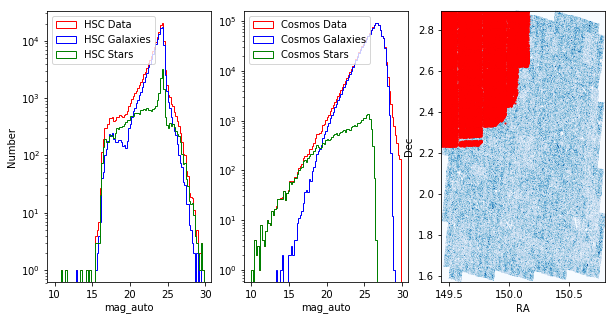

In [6]:
# plot number counts (stars and galaxies) and positional distribution
# use mu_class as star galaxy catalog
star_mu = 2
galaxy_mu = 1
unknown_mu = 3

# HSC
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,3,1)
bins = np.arange(10,30,0.2)

stars_mask = df_hsc['base_ClassificationExtendedness_value'] == 0.
galaxy_mask = df_hsc['base_ClassificationExtendedness_value'] == 1.
all_mask = np.bitwise_or(df_hsc['base_ClassificationExtendedness_value'] == 0.,
                                  df_hsc['base_ClassificationExtendedness_value'] == 1.)

ax.hist(psfMag[all_mask], bins=bins, color='red',range=(10., 30.), histtype='step', label='HSC Data')
ax.hist(psfMag[galaxy_mask], bins=bins, color='Blue',
        range=(10., 30.), histtype='step', label='HSC Galaxies')
ax.hist(psfMag[stars_mask], bins=bins, color='Green',
        range=(10., 30.), histtype='step', label='HSC Stars')

ax.set_xlabel('mag_auto')
ax.set_ylabel('Number')
ax.set_yscale('log')
ax.legend(loc='upper left')

# Cosmos
ax = fig.add_subplot(1,3,2)
bins = np.arange(10,30,0.2)
ax.hist(df_cosmos['mag_auto'], bins=bins, color='red',range=(10., 30.), histtype='step', label='Cosmos Data')
ax.hist(df_cosmos['mag_auto'][df_cosmos['mu_class'] == galaxy_mu], bins=bins, color='Blue',
        range=(10., 30.), histtype='step', label='Cosmos Galaxies')
ax.hist(df_cosmos['mag_auto'][df_cosmos['mu_class'] == star_mu], bins=bins, color='Green',
        range=(10., 30.), histtype='step', label='Cosmos Stars')

ax.set_xlabel('mag_auto')
# ax.set_ylabel('Number')
ax.set_yscale('log')
ax.legend(loc='upper left')

ax = fig.add_subplot(1,3,3)
ax.hist2d(df_cosmos['ra'], df_cosmos['dec'], bins=(300, 300), cmap='Blues')
# ax.hist2d(hsc_ra, hsc_dec, bins=(300, 300), cmap='Oranges')
ax.scatter(df_hsc['ra'], df_hsc['dec'], color='r', s=1)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
plt.show()

Make pre-matching of footprint

Make pre-matching of footprint

In [7]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u

In [8]:
# Get RA, Dec catalogs and convert to astropy SkyCoords 
mask = np.isfinite(df_cosmos['mag_auto'])
cosmos_ra = np.array(df_cosmos['ra'].values[mask])
cosmos_dec = np.array(df_cosmos['dec'].values[mask])
cosmos_mag = np.array(df_cosmos['mag_auto'].values[mask])

cosmos_coords = SkyCoord(cosmos_ra*u.degree,
                       cosmos_dec*u.degree, frame='icrs')
hsc_coords = SkyCoord(hsc_ra*u.degree,
                       hsc_dec*u.degree, frame='icrs')

In [9]:
idxc, idxcatalog, d2d, d3d = cosmos_coords.search_around_sky(hsc_coords, 10.*u.arcsec)

533901
187969


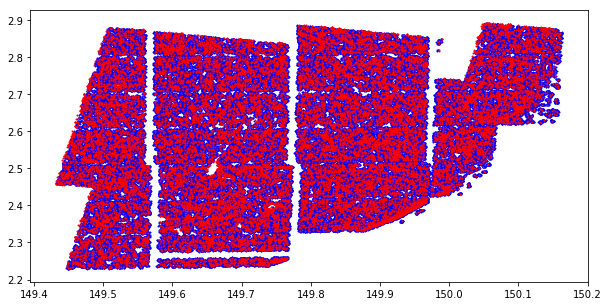

In [10]:
print(len(idxcatalog))
print(len(np.unique(idxcatalog)))

uniq_idxcatalog = np.unique(idxcatalog)
uniq_idx = np.unique(idxc)

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)

ax.scatter(cosmos_ra[uniq_idxcatalog], cosmos_dec[uniq_idxcatalog], color='b', s=1)
# ax.hist2d(hsc_ra, hsc_dec, bins=(300, 300), cmap='Oranges')
ax.scatter(hsc_ra[uniq_idx], hsc_dec[uniq_idx], color='r', s=1)

plt.show()



In [11]:
cosmos_footprint_ra, cosmos_footprint_dec, cosmos_footprint_mag = (cosmos_ra[uniq_idxcatalog], 
                                                                 cosmos_dec[uniq_idxcatalog], 
                                                                 cosmos_mag[uniq_idxcatalog])
hsc_footprint_ra, hsc_footprint_dec, hsc_footprint_mag = hsc_ra[uniq_idx], hsc_dec[uniq_idx], hsc_mag[uniq_idx]

# tmp_df_cosmos_footprint = copy.copy(df_cosmos.loc[uniq_idxcatalog])
# tmp_df_hsc_footprint = copy.copy(df_hsc.loc[uniq_idx])

In [13]:
# print(np.any(np.isnan(tmp_df_cosmos_footprint['mag_auto'])))
# print(np.any(np.isnan(tmp_df_hsc_footprint['modelMag'])))

In [16]:
# mask_valid = np.where(np.isfinite(tmp_df_cosmos_footprint['mag_auto']))
# df_cosmos_footprint = None
# df_cosmos_footprint = tmp_df_cosmos_footprint.loc[mask_valid]
# uniq_idxcatalog = uniq_idxcatalog[mask_valid]
# print(len(mask_valid[0]))
# print(len(tmp_df_cosmos_footprint))
# print(len(df_cosmos_footprint))
# print(df_cosmos_footprint)

In [17]:
# mask_valid = np.where(np.isfinite(tmp_df_hsc_footprint['modelMag']))
# # mask_nan = np.bitwise_not(np.isnan(df_hsc_footprint['modelMag']))
# df_hsc_footprint = None
# df_hsc_footprint = tmp_df_hsc_footprint.loc[mask_valid]
# uniq_idx = uniq_idx[mask_valid]
# print(len(mask_valid[0]))
# print(len(tmp_df_hsc_footprint))
# print(len(df_hsc_footprint))

In [18]:
# print(np.any(np.isnan(df_cosmos_footprint['mag_auto'].values)))
# print(np.any(np.isnan(df_hsc_footprint['modelMag'])))

# print(np.all(np.isfinite(df_cosmos_footprint['mag_auto'])))
# print(np.all(np.isfinite(df_hsc_footprint['modelMag'])))
# print(df_cosmos_footprint['mag_auto'].values)


Rebuild catalogs with cross-matched footprint

In [19]:
cosmos_coords = SkyCoord(cosmos_footprint_ra*u.degree,
                       cosmos_footprint_dec*u.degree, frame='icrs')
hsc_coords = SkyCoord(hsc_footprint_ra*u.degree,
                       hsc_footprint_dec*u.degree, frame='icrs')

Matching catalogs using cwalter approach https://github.com/cwwalter/DC1_Analysis/blob/master/Scripts/Match-Catalog.py

In [22]:
# Match with kd-tree - note all sources will be matched irrespective of distance
index, dist2d, dist3d = match_coordinates_sky(hsc_coords, cosmos_coords,
                                              nthneighbor=1, storekdtree=False)

#append match to input catalog
# print(len(df_hsc_footprint), len(index))
# df_hsc_footprint['match_index'] = index
# df_hsc_footprint['distance'] = dist2d.arcsec


In [24]:
# matched = df_hsc_footprint.join(df_cosmos_footprint, on='match_index', how='left',  lsuffix='_hsc', rsuffix='_cosmos')

In [ ]:
# matched.columns

In [25]:
#plot matches
delta_ra = hsc_footprint_ra - cosmos_footprint_ra[index]
delta_dec = hsc_footprint_dec - cosmos_footprint_dec[index]

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


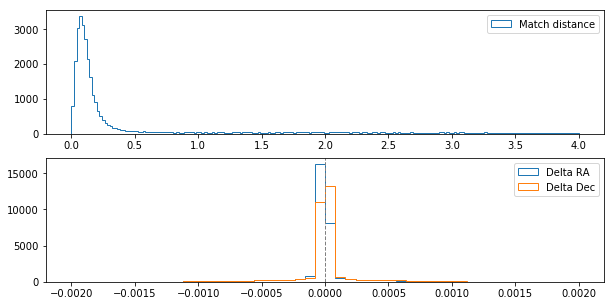

In [26]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(2,1,1)
bins = np.linspace(0., 4., 200.)
ax.hist(dist2d.arcsec, bins=bins, range=(-1., 1.), histtype='step', label='Match distance')
ax.legend(loc='upper right')

ax = fig.add_subplot(2,1,2)
ax.axvline(0., c='0.5', ls='--', lw=1)
bins = np.linspace(-.002, .002, 51.)
ax.hist(delta_ra, bins=bins, range=(-1., 1.), histtype='step', label='Delta RA')
ax.hist(delta_dec, bins=bins, range=(-1., 1.), histtype='step', label='Delta Dec')
ax.legend(loc='upper right')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


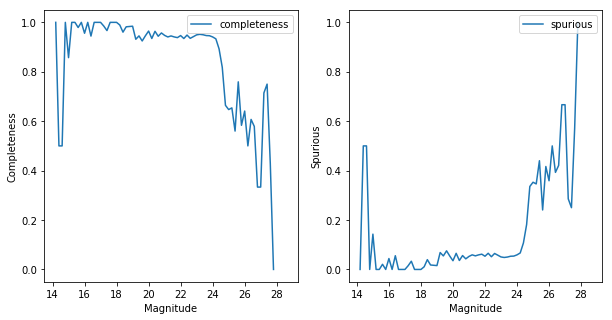

In [27]:
#plot completeness and spuriousness

match_radius = 3

#number of cosmos with hsc match
bins = np.arange(10.,30.,0.2)
num_cosmos, edges = np.histogram(cosmos_footprint_mag, bins=bins, range=(10.,30.))
good_hsc, edges = np.histogram(hsc_footprint_mag[dist2d.arcsec < match_radius], bins=bins, range=(10.,30.))

bad_hsc, edges = np.histogram(hsc_footprint_mag[dist2d.arcsec > match_radius], bins=bins, range=(10.,30.))
all_hsc, edges = np.histogram(hsc_footprint_mag, bins=bins, range=(10.,30.))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(edges[:-1],good_hsc/all_hsc, label='completeness')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Completeness')
ax.legend(loc='upper right')

ax = fig.add_subplot(1,2,2)
ax.plot(edges[:-1],bad_hsc/all_hsc, label='spurious')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Spurious')
ax.legend(loc='upper right')

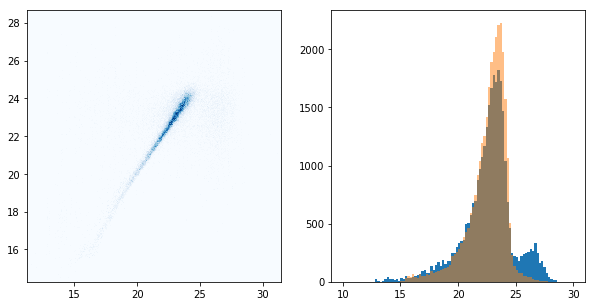

In [28]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

ax.hist2d(cosmos_footprint_mag[index],
          hsc_footprint_mag, bins=(300, 300), cmap='Blues',
        label='Mag COSMOS vs. HSC')

ax2 = fig.add_subplot(1,2,2)

a = ax2.hist(cosmos_footprint_mag[index], bins=100, range=(10,30))
b = ax2.hist(hsc_footprint_mag, bins=100, range=(10,30),alpha=0.5)

In [29]:
# print(np.any(np.isnan(df_cosmos_footprint['mag_auto'][df_hsc_footprint['match_index']])))
# print(np.any(np.isnan(df_hsc_footprint['modelMag'])))

In [272]:
# print(df_cosmos_footprint['mag_auto'][df_hsc_footprint['match_index']])